In [ ]:
!pip install kaggle tensorflow opencv-python pandas

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download paultimothymooney/blood-cells
!unzip blood-cells.zip -d dataset-master

Streaming output truncated to the last 5000 lines.
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset-master/dataset2-master/dataset2-maste

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
DATASET_DIR = os.path.join('dataset-master', 'dataset-master', 'dataset-master')
IMAGE_DIR = os.path.join(DATASET_DIR, 'JPEGImages')
LABELS_FILE = os.path.join(DATASET_DIR, 'labels.csv')
print("Paths set.")

Paths set.


In [ ]:
df = pd.read_csv(LABELS_FILE)

In [ ]:
df['Category'] = df['Category'].fillna('')
df = df[pd.to_numeric(df['Image'], errors='coerce').notnull()]
df['Image'] = df['Image'].astype(int)

In [ ]:
print("First few rows of the cleaned label file:")
print(df.head())

First few rows of the cleaned label file:
   Unnamed: 0  Image    Category
0         NaN      0  NEUTROPHIL
1         NaN      1  NEUTROPHIL
2         NaN      2  NEUTROPHIL
3         NaN      3  NEUTROPHIL
4         NaN      4  NEUTROPHIL


In [ ]:
classes = sorted(set(
    cell_type.strip()
    for category in df['Category']
    for cell_type in category.split(',') if cell_type.strip()
))
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
num_classes = len(classes)
print("Classes found:", classes)

Classes found: ['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:
def get_images_per_class(class_name, limit=50):
    """Get up to `limit` images for a specific class."""
    filtered_df = df[df['Category'].str.contains(class_name)]
    return filtered_df.sample(min(limit, len(filtered_df)), random_state=42)
selected_df = pd.concat([get_images_per_class(cls) for cls in classes])
selected_df = selected_df.sample(frac=1).reset_index(drop=True)
print(f"Selected {len(selected_df)} images for training.")

Selected 164 images for training.


In [ ]:
def load_and_preprocess_image(img_path):
    """Load and preprocess an image."""
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img

In [ ]:
X = []
y = []
for _, row in selected_df.iterrows():
    img_file = f"BloodImage_{int(row['Image']):05d}.jpg"
    img_path = os.path.join(IMAGE_DIR, img_file)
    if not os.path.exists(img_path):
        print(f"Warning: Image '{img_file}' not found.")
        continue
    img = load_and_preprocess_image(img_path)
    if img is None:
        print(f"Warning: Failed to load '{img_file}'.")
        continue

    X.append(img)
    label = np.zeros(num_classes)
    for category in row['Category'].split(','):
        cat = category.strip()
        if cat in class_to_index:
            label[class_to_index[cat]] = 1
    y.append(label)

In [ ]:
X = np.array(X)
y = np.array(y)
print("Images loaded and preprocessed.")
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Images loaded and preprocessed.
Dataset shape: (163, 128, 128, 3), Labels shape: (163, 5)


In [ ]:
if len(X) == 0 or len(y) == 0:
    raise ValueError("No images were loaded. Please check the image paths and filenames.")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)

Train shape: (130, 128, 128, 3)
Validation shape: (33, 128, 128, 3)


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.2261 - loss: 0.7108 - val_accuracy: 0.1818 - val_loss: 0.5901
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2655 - loss: 0.5577 - val_accuracy: 0.2121 - val_loss: 0.5258
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3079 - loss: 0.5054 - val_accuracy: 0.2424 - val_loss: 0.5077
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3008 - loss: 0.4946 - val_accuracy: 0.2727 - val_loss: 0.5040
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3805 - loss: 0.4620 - val_accuracy: 0.3030 - val_loss: 0.5009
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4044 - loss: 0.4419 - val_accuracy: 0.3030 - val_loss: 0.4960
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3483 - loss: 0.4584 - val_accuracy: 0.2424 - val_loss: 0.4920
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4531 - loss: 0.4310 - val_accuracy: 0.2424 - val_loss: 0.4894
E

In [ ]:
def predict_image(image_number, threshold=0.2):
    test_img_file = f"BloodImage_{int(image_number):05d}.jpg"
    test_img_path = os.path.join(IMAGE_DIR, test_img_file)
    if not os.path.exists(test_img_path):
        print(f"Error: Image '{test_img_file}' not found.")
        return
    test_img = load_and_preprocess_image(test_img_path)
    if test_img is None:
        print(f"Error loading image: {test_img_file}")
        return
    test_input = np.expand_dims(test_img, axis=0)
    prediction = model.predict(test_input)[0]
    print("Raw prediction scores:", prediction)
    predicted_labels = [cls for idx, cls in enumerate(classes) if prediction[idx] >= threshold]
    if not predicted_labels:
        top_idx = np.argmax(prediction)
        predicted_labels = [classes[top_idx] + " (low confidence)"]
    plt.imshow(test_img)
    plt.title(f"Predicted: {', '.join(predicted_labels)}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw prediction scores: [0.02586786 0.35697046 0.15852773 0.08696344 0.4603697 ]


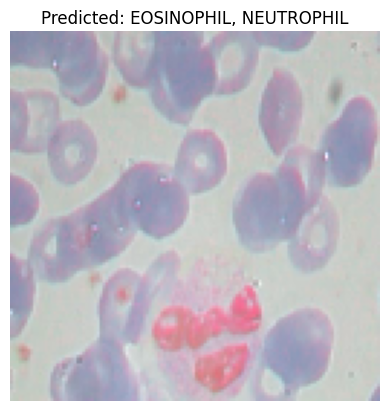

In [ ]:
predict_image(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Raw prediction scores: [0.01039679 0.40262577 0.16802119 0.19925626 0.12645781]


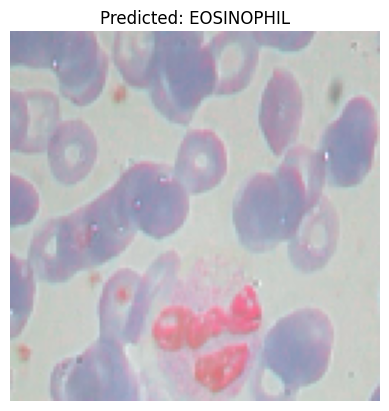

In [ ]:
predict_image(5)